# Численное решение дифференциальных уравнений

## 2. Применение пакета DifferentialEquations.jl

Пакет [DifferentialEquations.jl](https://diffeq.sciml.ai/stable/) предоставляет большое количество хорошо оптимизированных решателей дифференциальных уравнений различного типа:
- обыкновенные дифференциальные уравнения
- дифференциально-алгебраические уравнения
- стохастические дифференциальные уравнения
- дифференциальные уравнения с запаздывающим аргументом
- стохастические дифференциальные уравнения с запаздывающим аргументом
- дифференциальные уравнения с параметрической неопределенностью
- и др.

In [1]:
using DifferentialEquations, Plots

### 2.1 Решение скалярного дифференциального уравнения

Рассмотрим дифференциальное уравнение из примера выше: $$\frac{dy}{dt}=y(1-y)$$  $$y_0=10^{-5}$$

Общий порядок действий следующий:

**1. Задать функцию**
```
f(u, p, t) 
f(du, u, p, t)
```
где `u` - переменные, `p` - параметры уравнения, `du` - производные $dy/dt$. В первом случае функция возвращает текущие значения $dy/dt$ в точке $t$, во втором случае производные вычисляются in-place, тем самым исключая выделение памяти

**2. Определить задачу** 
```
prob = ODEProblem(f, u0, tspan)
prob = ODEProblem(f, u0, tspan, p)
```

где `u0` - начальные условия, `tspan` - расчетный интервал времени ($t_0, T$)

**3. Численное решение**
```
sol = solve(prob, alg; kwargs)
```

где `alg` - численный алгоритм, `kwargs` - дополнительные аргументы 

**4. Анализ результатов**
```
sol(t)
plot(sol)
```

где используется функция `plot` пакета Plots.jl. При использовании других графических пакетов 
```
plot(sol.t, sol')
```

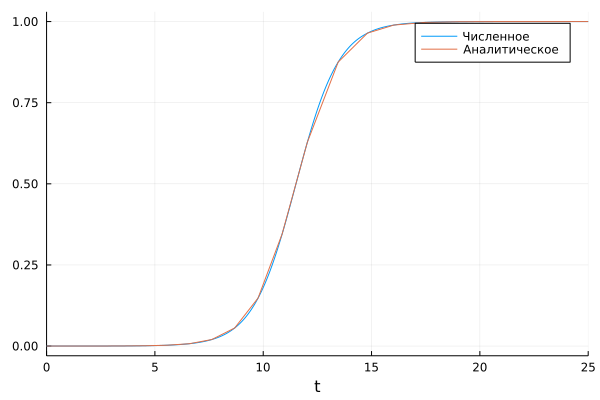

In [2]:
f(u, p, t) = u * (1 - u)                 # задание функции

prob = ODEProblem(f, 1e-5, (0.0, 25.0))  # определение задачи
sol = solve(prob)                        # решение задачи

plot(sol, label="Численное")
plot!(sol.t, t -> 1 ./ (1 .- (1-1e5) * exp.(-t)), label="Аналитическое")

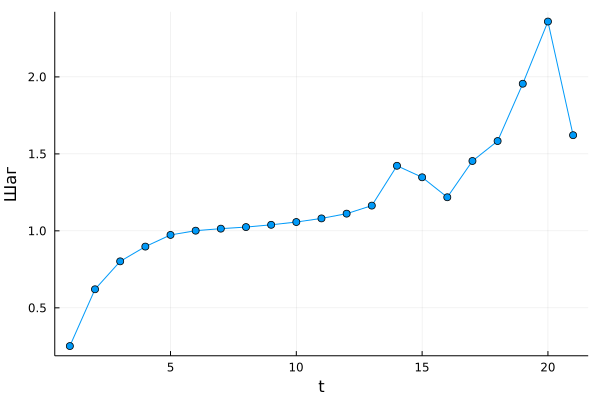

In [3]:
plot(diff(sol.t), markershape=:circle, label="", ylabel="Шаг", xlabel="t") # величина шага 

Решение `sol` содержит массив точек времени `sol.t` и массив рассчитанных значений переменной `sol.u` в них

In [4]:
sol.t     # получить массив точек времени
sol.u     # получить массив значений переменной
sol[14]   # получить значение переменной в точке 14
sol.t[14] # получить значение времени в точке 14

12.038135914282291

Если `solve` вызывается с опцией `dense=true` (по умолчанию), тогда `sol` - фактически непрерывная функция, позволяющая получить значение переменной в любой момент времени за счет интерполяции

In [5]:
sol(14.01)  # получить значение переменной в момент t=10.234

0.9241971772498271

Структура `sol` также несет следующую информацию:
- `sol.prob` решаемая задача
- `sol.alg`, использованный алгоритм
- `sol.destats` статистика расчета (число обращений к функции и пр.)
- `sol.retcode` код о выполнении, возвращаемый решателем

In [6]:
sol.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  129
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          21
Number of rejected steps:                          0
Maximum eigenvalue recorded:                       1

### 2.2 Дополнительные опции функции `solve`

`adaptive` - использовать адаптивный шаг (по умолчанию true) 

`abstol` - допустимая абсолютная ошибка (по умолчанию для ОДУ 1e-6)

`reltol` - допустимая относительная ошибка (по умолчанию для ОДУ 1e-3)

`dt` - начальное значение шага для алгоритмов с переменным шагом, величина шага для алгоритмов с фиксированным шагом

`dtmax` - максимальный шаг для алгоритмов с переменным шагом

`dtmin` - минимальный шаг для алгоритмов с переменным шагом


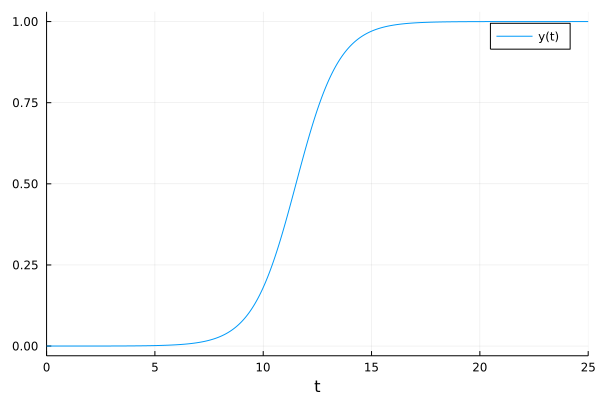

In [7]:
sol = solve(prob, adaptive = false, dt = 0.1) # расчет с постоянным шагом h=0.01

plot(sol, label="y(t)")

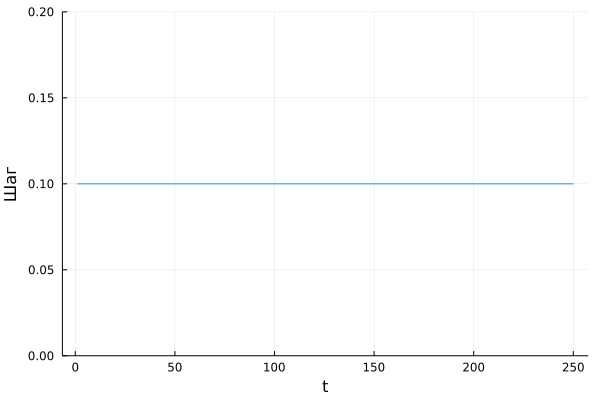

In [9]:
plot(diff(sol.t), label="", ylabel="Шаг", xlabel="t", ylims=(0,0.2)) # величина шага 

`saveat` - массив точек времени, в которые значения переменной сохраняются в `sol`. Если задано число, то сохранение будет в равноотстоящие моменты с шагом saveat

`save_idx` - индексы переменных для сохранения (в случае, если решается система уравнений)

`tstop` - дополнительные точки времени, в которые алгоритм должен вычислить переменную

`save_everystep` - сохранять результат на каждом шаге (по умолчанию true)

`save_start` - включение начального условия в результат (по умолчанию true)

`save_end` - включение конечной точки в результат (по умолчанию true)

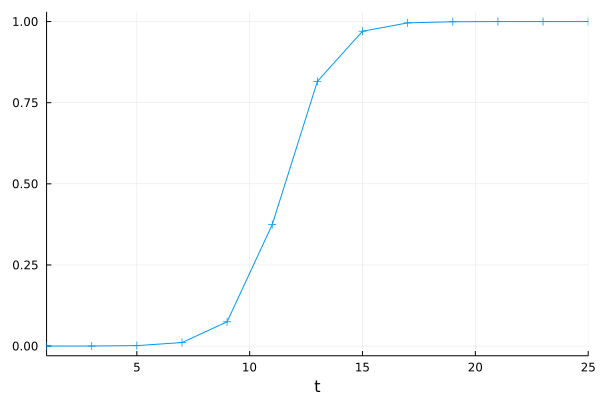

In [10]:
sol = solve(prob, saveat=1:2:25) # сохранять каждые 2 сек

plot(sol, label="", markershape=:cross)

DifferentialEquations.jl автоматически выбирает численный алгоритм, исходя из заданных условий расчета (ограничений на шаг, точность и др.). Можно помочь ему, указав 

`alg_hints=:stiff` - задача относится к жестким 

`alg_hints=:nonstiff` - задача к жестким не относится 

В ряде случаев целесообразно явно указать алгоритм решения. [Список](https://diffeq.sciml.ai/stable/solvers/ode_solve/) доступных решателей обыкновенных дифференциальный уравнений весьма обширный и включает как алгоритмы, написанные на Julia, так алгоритмы, реализованные на других языках


In [11]:
sol = solve(prob, Vern7()); # использовать явный "наиболее эффективный" метод Рунге-Кутты Вернера порядка 7(6)

Алгоритмы имеют свои локальные настройки

In [12]:
using Sundials # С-библиотека алгоритмов Sundials

sol = solve(prob, ARKODE(Sundials.Implicit(),order = 5)); # использовать неявный алгоритм порядка 5 из набора ARCODE

### 2.3 Дополнительные опции функции `plot` пакета Plots.jl

`tspan` - диапазон времени (зумминг по оси времени)

`vars` - массив индексов переменных (в случае если решается система уравнений), отобажаемых на графике, индекс 0 - время

`denseplot` - использовать интерполированное решение (по умочанию true)

`plotdensity` - число равноотстоящих по времени точек, используемых для построения графика (при denseplot=true)

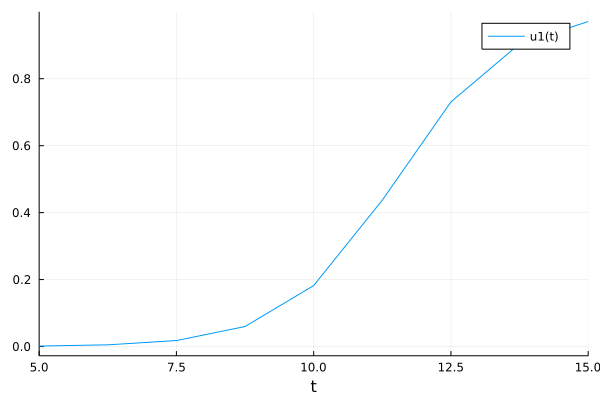

In [13]:
plot(sol, lable = "y(t)", tspan = (5,15), plotdensity=9)

### 2.4 Решение системы обыкновенных дифференциальных уравнений

Рассмотрим систему уравнений Робертсона, описывающую некоторую химическую реакцию

\begin{equation*}
 \begin{cases}
   \frac{dx}{dt} = -0.04x+10^4yz, 
   \\
   \frac{dy}{dt} = 0.04x - 10^4yz-3 \times 10^7y^2,
   \\
   \frac{dz}{dt} = 3 \times10^7y^2.
 \end{cases}
\end{equation*}

$$ x(0)=1, y(0)=0, z(0)=0$$

Процесс решения системы уравнений не отличается от решения скалярного уравнения

In [14]:
function robertson!(du, u, p, t)  # in-place расчет 
    x, y, z = u
    k₁, k₂, k₃ = p
    du[1] = -k₁*x + k₂*y*z
    du[2] =  k₁*x - k₂*y*z - k₃*y^2
    du[3] =  k₃*y^2
    nothing
end    

robertson! (generic function with 1 method)

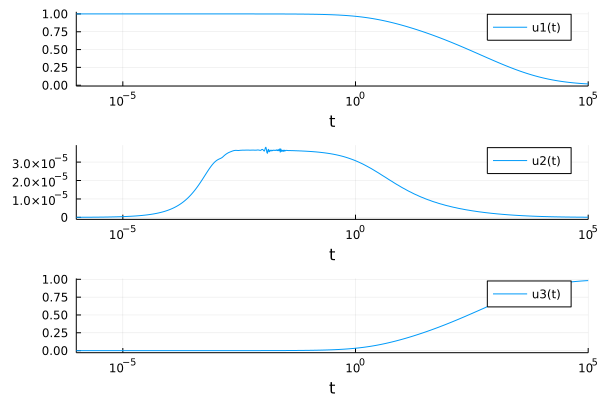

In [15]:
u0 = [1.0, 0.0, 0.0]      # начальные значения переменных
tspan = (0.0, 1e5)        # интервал времени расчета
params = [0.04, 1e4, 3e7] # параметры модели

prob = ODEProblem(robertson!, u0, tspan, params)
sol = solve(prob)

plot(sol, tspan=(1e-6, 1e5), xscale=:log10, layout=(3,1))

In [16]:
sol.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  568
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    51
Number of linear solves:                           153
Number of Jacobians created:                       51
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          73
Number of rejected steps:                          4
Maximum eigenvalue recorded:                       3854897501259276682711923808486549111462428672

Система уравнений относится к жестким. Для жестких систем рекомендуется использовать **неявные** методы численного интегрирования, такие как `Rosenbrock23`, `TRBDF2`, `Rodas4P` и др.

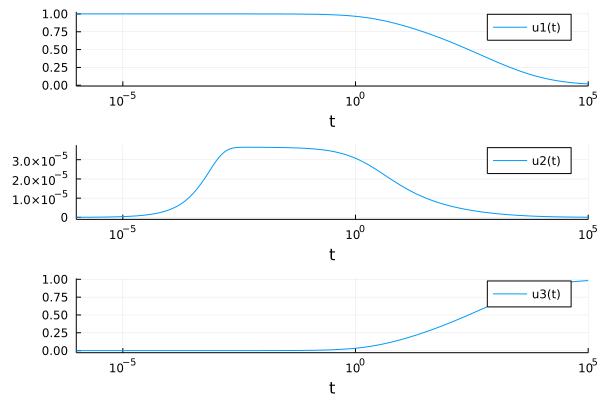

In [17]:
sol = solve(prob, Rodas4P())

plot(sol, tspan=(1e-6, 1e5), xscale=:log10, layout=(3,1))

### 2.5 Сравнение явных и неявных методов по скорости

Рассмотрим большую систему линейных дифференциальных уравнений вида

$$\frac{dy}{dt}=-A_n y $$

где $A_n$ - положительно определенная матрица $n \times n$

In [18]:
# Размерность системы
n = 1000

# Сгенерируем случайную матрицу A
B = randn(2n,n)
A = B'*B./n

# Зададим функцию
function matdiff!(du, u, A, t)
    du[:] = - A*u
    nothing
end

# Определим задачу
u0 = 10*randn(n)
tspan = (0,20)
prob = ODEProblem(matdiff!, u0, tspan, A);

  0.545838 seconds (1.32 k allocations: 2.126 GiB, 14.37% gc time)
 16.665965 seconds (19.73 k allocations: 30.232 GiB, 3.14% gc time)


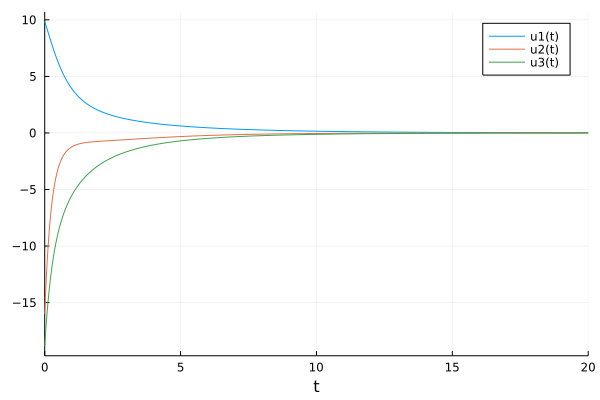

In [20]:
# Расчет явным методом Tsit5 и неявным методом Rodas4
@time sol_expl = solve(prob, Tsit5(),  save_idxs = [1, 3, 15])
@time sol_impl = solve(prob, Rodas4(), save_idxs = [1, 3, 15])


plot(sol_expl)

In [21]:
sol_expl.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  285
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          46
Number of rejected steps:                          1

In [22]:
sol_impl.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  354
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    44
Number of linear solves:                           264
Number of Jacobians created:                       44
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          44
Number of rejected steps:                          0

### 2.6 Примеры

### Переходные процессы в RL цепи

![Image](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ5w9BwfL6YNcFfAhRd-Ow-eLJf1SXaSx4UPg&usqp=CAU)

Пусть в цепи ключ замыкается в момент $t_0$. Уравнение, описывающее процесс изменения тока имеет вид:

$$e = ri+L\frac{di}{dt}$$

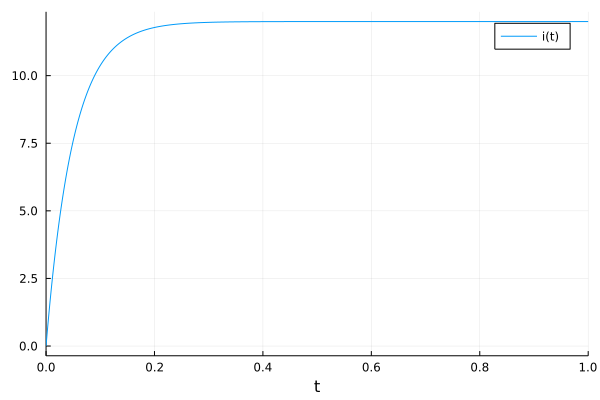

In [23]:
r = 2
L = 0.1
E = 24

function RL(u, p, t)
    r, L, E = p
    (E - r * u) / L
end

prob = ODEProblem(RL, 0.0, (0,1), [r, L, E])
sol = solve(prob)

plot(sol, label="i(t)")

### Переходные процессы в RLC цепи

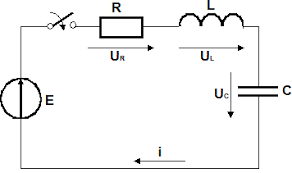

Для этой цепи имеем

$$e = ri+L\frac{di}{dt}+u_c$$
$$i = C\frac{du_c}{dt}$$

In [ ]:
# Самостоятельно